# EVeMa 2018
![title](evema-logo.jpeg)
- Instructor: M.Sc. Blaž Meden, M.Sc. Žiga Emeršič

- Authors: 
    - Saúl Calderón, Žiga Emeršič, Ángel García, Blaž Meden, Felipe Meza, Juan Esquivel, Martín Solís
    - Mauro Méndez, Manuel Zumbado. 
    
# Face Detection with Single Shot Detector

## Intuition

Key idea in SSD detector is single network (for speed) and no need for region proposals instead it uses different bounding boxes and then adjust the bounding box as part of prediction. Different bounding box predictions is achieved by each of the last few layers of the network responsible for predictions for progressively smaller bounding box and final prediction is union of all these predictions.

SSD, discretizes the output space of bounding boxes into a set of default boxes over different aspect ratios and scales per feature map location. At prediction time, the network generates scores for the presence of each object category in each default box and produces adjustments to the box to better match the object shape. The fundamental improvement in speed comes from eliminating bounding box proposals and the subsequent pixel or feature resampling stage.

![framework](1-ssd-framework.jpeg)

## Model
The SSD approach is based on a feed-forward convolutional network that produces a fixed-size collection of bounding boxes and scores for the presence of object class instances in those boxes, followed by a non-maximum suppression step to produce the final detections ( for bounding boxes with most overlap keep the one with highest score).

The early network layers are based on a standard architecture used for high quality image classification (truncated before any classification layers), which we will call the base network. We then add auxiliary structure to the network to produce detections with the following key features:

### Multi-scale feature maps for detection: 

We add convolutional feature layers to the end of the truncated base network. These layers decrease in size progressively and allow predictions of detections at multiple scales. The convolutional model for predicting detections is different for each feature layer (cf Overfeat[4] and YOLO[5] that operate on a single scale feature map).

### Convolutional predictors for detection: 

Each added feature layer (or optionally an existing feature layer from the base network) can produce a fixed set of detection predictions using a set of convolutional filters. These are indicated on top of the SSD network architecture in Fig. 2. For a feature layer of size m × n with p channels, the basic element for predicting parameters of a potential detection is a 3 × 3 × p small kernel that produces either a score for a category, or a shape offset relative to the default box coordinates. At each of the m × n locations where the kernel is applied, it produces an output value. The bounding box offset output values are measured relative to a default box position relative to each feature map location (cf the architecture of YOLO[5] that uses an intermediate fully connected layer instead of a convolutional filter for this step).

### Default boxes and aspect ratios:

Authors of SSD approach associate a set of default bounding boxes with each feature map cell, for multiple feature maps at the top of the network. The default boxes tile the feature map in a convolutional manner, so that the position of each box relative to its corresponding cell is fixed. At each feature map cell, we predict the offsets relative to the default box shapes in the cell, as well as the per-class scores that indicate the presence of a class instance in each of those boxes. Specifically, for each box out of k at a given location, we compute c class scores and the 4 offsets relative to the original default box shape. This results in a total of (c + 4)k filters that are applied around each location in the feature map, yielding (c + 4)kmn outputs for a m × n feature map. For an illustration of default boxes, please refer to Fig. 1. Our default boxes are similar to the anchor boxes used in Faster R-CNN [2], however the authors apply them to several feature maps of different resolutions. Allowing different default box shapes in several feature maps let us efficiently discretize the space of possible output box shapes.

![compare-yolo-ssd](2-comparison.jpeg)

## Training
The key difference between training SSD and training a typical detector that uses region proposals, is that ground truth information needs to be assigned to specific outputs in the fixed set of detector outputs. Training also involves choosing the set of default boxes and scales for detection as well as the hard negative mining and data augmentation strategies.


### Hard negative mining: 

After the matching step, most of the default boxes are negatives, especially when the number of possible default boxes is large. This introduces a significant imbalance between the positive and negative training examples. Instead of using all the negative examples, we sort them using the highest confidence loss for each default box and pick the top ones so that the ratio between the negatives and positives is at most 3:1. We found that this leads to faster optimization and a more stable training.


In [1]:
import numpy as np
import cv2
import keras

from Detector import Detector

d=Detector()
   

img = cv2.imread('IWOBIcrew.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = d.detect(img,True)

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #roi_gray = gray[y:y+h, x:x+w]
    #roi_color = img[y:y+h, x:x+w]
cv2.destroyAllWindows()
    
images = [img]

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


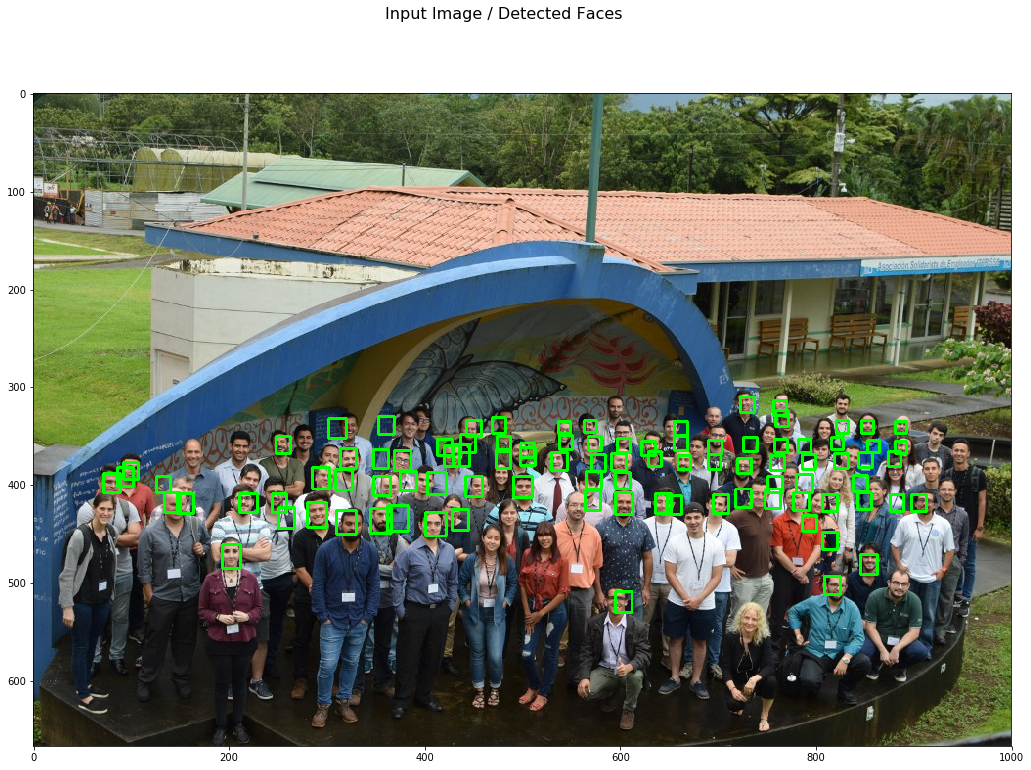

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
fig.suptitle("Input Image / Detected Faces", fontsize=16)

for ix, image in enumerate(images):
    ax = plt.subplot("11" + str(ix+1))
    #ax.set_title("k = " + str(len(ids)) + ", Expression: " + emo)
    ax.imshow(image)
    
# show the generated faces
plt.show()

Authors: *Saul Calderon, Angel García, Blaz Meden, Felipe Meza, Juan Esquivel, Martín Solís, Ziga Emersic, Mauro Mendez, Manuel Zumbado*

References: 
    - https://medium.com/@ManishChablani/ssd-single-shot-multibox-detector-explained-38533c27f75f
    - https://arxiv.org/abs/1512.02325
    - https://github.com/yeephycho/tensorflow-face-detection